In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('D:\\User\Zhixuan Ge\Onedrive TUDelft\OneDrive - Delft University of Technology\Courses\ML for EE\SZD\S&S_SZD\Project_Data_EE4C12_S&S_SZD.csv')
data

,Patient,annotation,min|FP1-F7,min|F7-T3,min|T3-T5,min|T5-O1,min|FP2-F8,min|F8-T4,min|T4-T6,min|T6-O2,...,norm_power_HF|CZ-C4,norm_power_HF|C4-T4,norm_power_HF|FP1-F3,norm_power_HF|F3-C3,norm_power_HF|C3-P3,norm_power_HF|P3-O1,norm_power_HF|FP2-F4,norm_power_HF|F4-C4,norm_power_HF|C4-P4,norm_power_HF|P4-O2
0,258,1,50,61,57,53,39,35,39,35,...,0.016087,0.066920,0.102402,0.481384,0.690787,0.154544,0.062533,0.046460,0.066575,0.086999
1,258,1,48,62,60,46,38,35,39,33,...,0.024006,0.064857,0.031791,0.225788,0.409987,0.184671,0.071133,0.022369,0.079494,0.047536
2,258,1,51,60,59,45,38,36,40,36,...,0.037326,0.100177,0.050009,0.622584,0.394504,0.225516,0.050673,0.044906,0.102142,0.068105
3,258,1,49,58,56,42,36,36,41,37,...,0.027546,0.107883,0.014017,0.359140,0.276964,0.104977,0.018042,0.079467,0.078255,0.089385
4,258,1,45,57,61,41,35,37,41,37,...,0.036820,0.182520,0.031397,0.328354,0.156929,0.151952,0.047532,0.135071,0.098320,0.137701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55451,11580,-1,75,73,81,80,66,80,77,75,...,0.244334,0.625396,0.023821,0.058277,0.083594,0.114426,0.119654,0.295364,0.185930,0.199585
55452,11580,-1,74,74,77,71,79,75,82,77,...,0.588236,0.743060,0.076294,0.332341,0.228458,0.170603,0.351418,0.638666,0.490806,0.307429
55453,11580,-1,72,76,72,73,74,76,80,76,...,0.296041,0.770194,0.041190,0.090919,0.186074,0.216797,0.231053,0.770637,0.285257,0.413382
55454,11580,-1,77,82,74,75,82,85,80,76,...,0.440360,0.720855,0.026959,0.026340,0.077674,0.269610,0.186769,0.790173,0.473615,0.415771


In [4]:
data.columns.shape

(362,)

In [5]:
y = np.int32(data['annotation'].values)
X = data.iloc[:, 2:].values

In [6]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [7]:
Shuffle_state = 42
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=Shuffle_state)

In [30]:
n_p = data['annotation'].value_counts()[1]
n_n = data['annotation'].value_counts()[-1]
n_z = data['annotation'].value_counts()[0]

w_p = 1 - n_p / (n_p + n_n + n_z)
w_n = 1 - n_n / (n_p + n_n + n_z)
w_z = 1 - n_z / (n_p + n_n + n_z)
weights = {-1:w_n, 1: w_p, 0:w_z}

In [33]:
#Logistic regression
clf_lr = LogisticRegression(max_iter=1000, class_weight=weights).fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

In [34]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8421090594345066
F1 score: 0.8421090594345066
Recall score: 0.8421090594345066
Precision score: 0.8421090594345066


In [10]:
# not possible for multi-classification
'''#ROC curve

y_score_train = clf_lr.decision_function(X_train)
y_score_test = clf_lr.decision_function(X_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train, pos_label=clf_lr.classes_[1])
fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test, pos_label=clf_lr.classes_[1])

ax = plt.gca()
train_disp = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train)
train_disp.plot(ax, name='Train')

test_disp = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test)
test_disp.plot(ax, name='Test')

plt.legend()
plt.show()'''

"#ROC curve\n\ny_score_train = clf_lr.decision_function(X_train)\ny_score_test = clf_lr.decision_function(X_test)\nfpr_train, tpr_train, _ = roc_curve(y_train, y_score_train, pos_label=clf_lr.classes_[1])\nfpr_test, tpr_test, _ = roc_curve(y_test, y_score_test, pos_label=clf_lr.classes_[1])\n\nax = plt.gca()\ntrain_disp = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train)\ntrain_disp.plot(ax, name='Train')\n\ntest_disp = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test)\ntest_disp.plot(ax, name='Test')\n\nplt.legend()\nplt.show()"

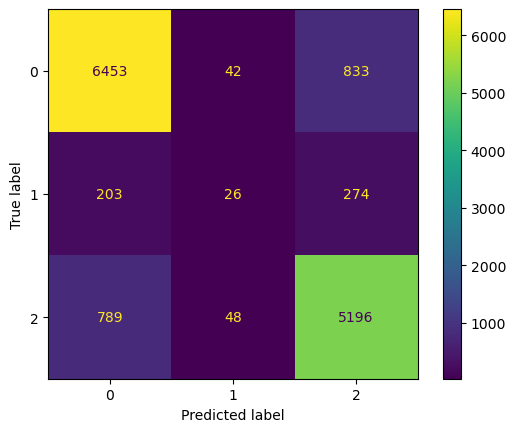

In [35]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

In [12]:
clf_svm = svm.SVC(max_iter=2000,random_state=Shuffle_state).fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

d:\Languages\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [13]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.542267743796884
F1 score: 0.542267743796884
Recall score: 0.542267743796884
Precision score: 0.542267743796884


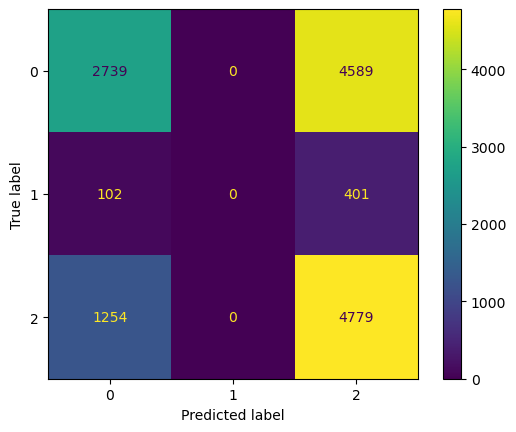

In [14]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

In [26]:
n_p = data['annotation'].value_counts()[1]
n_n = data['annotation'].value_counts()[-1]
n_z = data['annotation'].value_counts()[0]

w_p = 1 - n_p / (n_p + n_n + n_z)
w_n = 1 - n_n / (n_p + n_n + n_z)
w_z = 1 - n_z / (n_p + n_n + n_z)

In [27]:
print([w_p, w_n, w_z])

[0.5634376803231391, 0.4721220427005194, 0.9644402769763416]


In [28]:
hl_size = (256, 128, 128, 64)
clf_mlp = MLPClassifier(hidden_layer_sizes=hl_size, activation='relu', solver='adam', class_weight=[w_p, w_n, w_z],
                        alpha=0.0001, max_iter=1000, shuffle=True, random_state=Shuffle_state, verbose=True)
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

TypeError: MLPClassifier.__init__() got an unexpected keyword argument 'class_weight'

In [20]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8914454702827467
F1 score: 0.8914454702827467
Recall score: 0.8914454702827467
Precision score: 0.8914454702827467


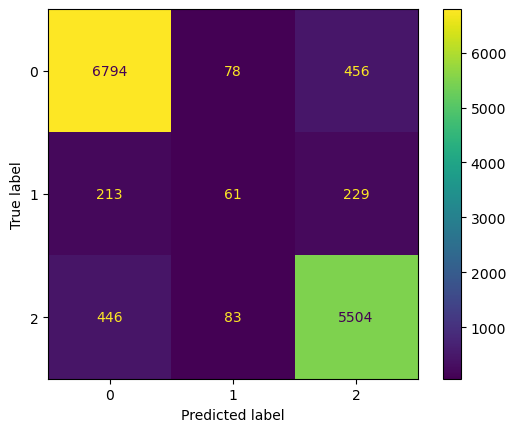

In [21]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()